<a href="https://colab.research.google.com/github/GrzegorzAndrzejczak/Programowanie-w-Pythonie/blob/main/CASE-lighthouse(16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dane: lighthouse.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)  # for repeatability
# Load the data on the recorded positions
d = pd.read_csv('sample_data/lighthouse.csv')
N = 16  # number of measurements
D = d.values[:N]
print(D.T,f"średnio: {D.mean()}")

ndim = 2  # number of parameters in the model
nwalkers = 10000  # number of MCMC walkers = rozmiar każdej z próbek w ciągu
# nburn = 500     # "burn-in" period to let chains stabilize
nsteps = 8000     # liczba iteracji w MCMC

import warnings
def log_prior(a,b):
    mask = b<=0
    b[mask] = 0
    result = -b**(-1)
    # result[mask] = -np.inf
    return result  #   //nearly flat prior, składnik 1/b odsuwa od b=0

def log_likelihood(a, b, Data):
    mask = b<=0
    b[mask] = 0
    result = -np.sum(np.log((Data - a)**2 + b**2)-np.log(b), axis=0)
    # result[mask] = -np.inf
    return result

def log_posterior(a, b, Data):
    warnings.simplefilter("ignore")
    return log_prior(a, b) + log_likelihood(a, b, Data)

def compute_log_prob(coords):
    return log_posterior(*coords.T, D)



[[ 31.04551878  39.15193522   1.81317194 -10.04647801  -2.2359284
    5.63464564   4.32362938 -30.53652884  -9.71757994  31.32393253
   23.68015512  32.49662434 -31.35559132  58.09323785 -21.02318899
   42.46499599]] średnio: 10.319534455475154


### 1. MCMC - Metropolis-Hastings

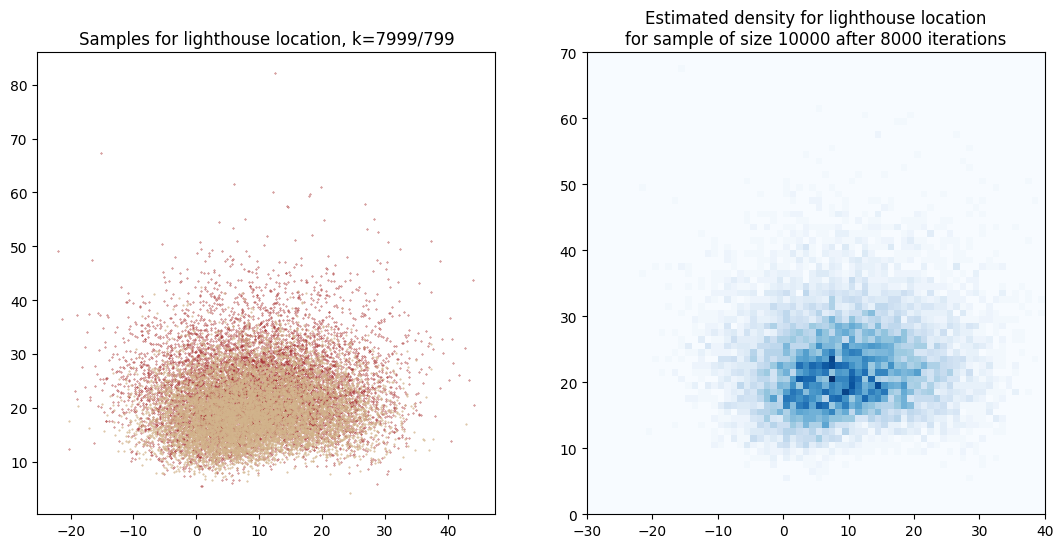

In [2]:
paths3 = np.empty((nsteps, nwalkers, ndim), dtype = np.float32)
np.random.seed(123)
ab = np.random.rand(nwalkers,ndim)*20
log_post = log_posterior(*ab.T, D)

for k_ in range(nsteps):
    ab_ = ab + np.random.randn(nwalkers,ndim)/3     # stąd nazwa paths3
                  #  !!! był DUŻY BŁĄD: (ndim) - a przecież każda para zmienia się indywidualnie!
    log_post_ = log_posterior(*ab_.T, D)
    H_ = log_post_ - log_post
    u_ = np.log(np.random.uniform(size=nwalkers))
    where = u_ < H_
    ab[where] = ab_[where]
    log_post[where] = log_post_[where]
    paths3[k_] = ab
paths = paths3
fig, (axn,ax) = plt.subplots(1, 2, figsize=(13, 6))
axn.scatter(*paths[k_].T, s=.1, c="brown")
axn.scatter(*paths[k_//10].T, s=.2, c="tan")
# axs.set_aspect(1)
axn.set_title(f"Samples for lighthouse location, k={k_}/{k_//10}")
path = paths[-1]
Hb, xb, yb = np.histogram2d(*path.T, bins=140, density=True, range=np.asarray([[-70,70],[0,140]]))
Xb, Yb = np.meshgrid(xb, yb)
ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.pcolormesh(Xb, Yb, Hb.T, cmap="Blues");
ax.set_title(f"Estimated density for lighthouse location\n"
            f"for sample of size {nwalkers} after {nsteps} iterations");

    0:  0.731; [ 9.991949 10.046442]
 2000:  0.205; [ 9.183203 21.860113]
 4000:  0.209; [ 9.072358 22.580145]
 6000:  0.201; [ 9.190394 22.925844]


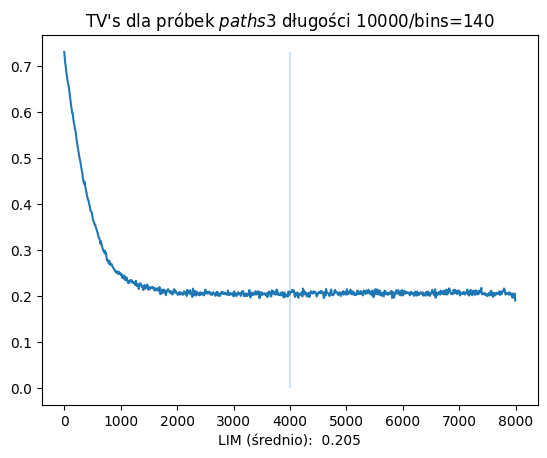

In [3]:
path = paths[-1]    # ostatnia - graniczna w łańcuchu paths3
bins = 140
Hb, xb, yb = np.histogram2d(*path.T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))
for k in np.arange(0,nsteps,2000):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))
    tm_ = np.abs(H_ - Hb).sum()/2*(140/bins)**2
    print(f'{k:5}: {tm_:6.3f}; {path_.mean(axis=1)}')
n_rang = np.arange(nsteps,step=10)
tv_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))
    tv_ = np.abs(H_ - Hb).sum()/2
    tv_vals[i] = tv_
tv_vals *= (140/bins)**2   # podział na bins^2 zamiast 140^2
fig, ax0 = plt.subplots()
ax0.plot(n_rang, tv_vals)
nburn = 4000
ax0.vlines(nburn, 0, tv_vals[0],lw=.3)
ax0.set_title(f"TV's dla próbek $\\it paths3$ długości {nwalkers}/bins={bins}")
ax0.set_xlabel(f"LIM (średnio): {tv_vals[nburn//10-100:nburn//10+100].mean():6.3f}");


Wygląda na to, że próbki  _paths3_ o długości 10K modyfikowane (warunkowo - MH) wg reguły

    ab_ = ab + np.random.randn(nwalkers,ndim)/3

stabilizują błąd $\;\sim\!\|\cdot\|_{TV}$ na poziomie ok. **0.205** już dla **nsteps=3K.**

Dla odmiany, próbki _paths10_ o długości 10K modyfikowane (warunkowo - MH) wg reguły

    ab_ = ab + np.random.randn(nwalkers,ndim)/10

stabilizują błąd $\;\sim\!\|\cdot\|_{TV}$ na poziomie ok. **0.179** dla **nsteps=12.5K.**

In [4]:
nsteps = 14000
paths10 = np.empty((nsteps, nwalkers, ndim), dtype = np.float32)
np.random.seed(123)
ab = np.random.rand(nwalkers,ndim)*20
log_post = log_posterior(*ab.T, D)

for k_ in range(nsteps):
    ab_ = ab + np.random.randn(nwalkers,ndim)/10    # stąd nazwa paths10
    log_post_ = log_posterior(*ab_.T, D)
    H_ = log_post_ - log_post
    u_ = np.log(np.random.uniform(size=nwalkers))
    where = u_ < H_
    ab[where] = ab_[where]
    log_post[where] = log_post_[where]
    paths10[k_] = ab
path = paths10[-1]    # ostatnia - graniczna
bins = 140
Hb, xb, yb = np.histogram2d(*path.T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
for k in np.arange(0,nsteps,2000):
    path_ = paths10[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))
    tv_ = np.abs(H_ - Hb).sum()/2*(140/bins)**2
    print(f'{k:5}: {tv_:6.3f}; {path_.mean(axis=1)}')


    0:  0.686; [ 9.995963 10.005581]
 2000:  0.491; [ 9.480024 15.078654]
 4000:  0.340; [ 9.153475 17.106125]
 6000:  0.248; [ 8.989947 18.420425]
 8000:  0.203; [ 8.97785  19.361122]
10000:  0.189; [ 8.954936 19.97228 ]
12000:  0.180; [ 8.91969 20.49502]


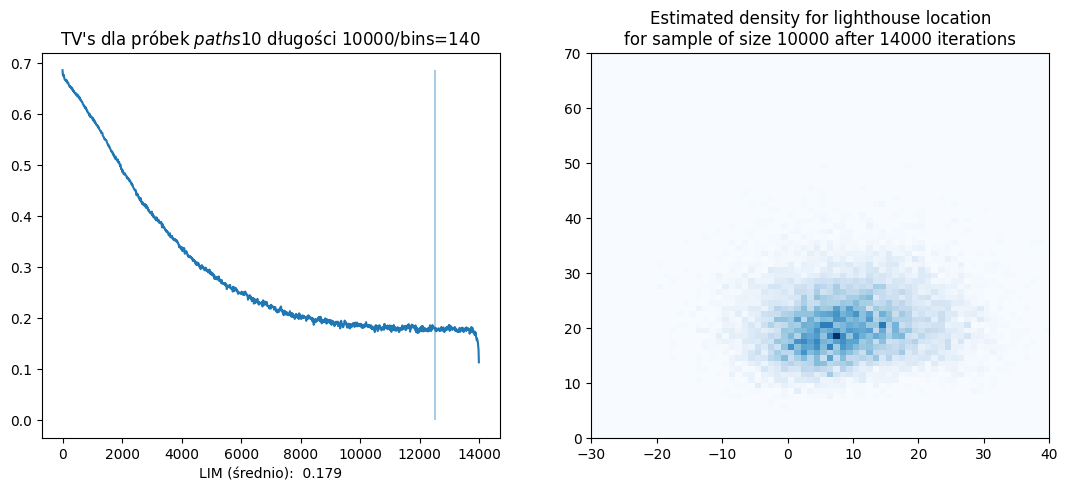

In [5]:
paths = paths10
n_rang = np.arange(nsteps,step=10)
tv_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tv_ = np.abs(H_ - Hb).sum()/2
    tv_vals[i] = tv_
tv_vals *= (140/bins)**2   # podział na bins^2 zamiast 140^2
fig, (ax0, ax) = plt.subplots(1,2,figsize=(13,5))
nburn = 12500
ax0.vlines(nburn, 0, tv_vals[0],lw=.3)
ax0.set_title(f"TV's dla próbek $\\it paths10$ długości {nwalkers}/bins={bins}")
ax0.set_xlabel(f"LIM (średnio): {tv_vals[nburn//10-100:nburn//10+100].mean():6.3f}");    # 100: 0.174,  140: 0.232
ax0.plot(n_rang, tv_vals)
ax0.vlines(nburn, 0, tv_vals[0],lw=.3)
Xb, Yb = np.meshgrid(xb, yb)
ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.pcolormesh(Xb, Yb, Hb.T, cmap="Blues");
ax.set_title(f"Estimated density for lighthouse location\n"
            f"for sample of size {nwalkers} after {nsteps} iterations");


Efektywna *zbieżność* uzyskana wcześniej dla próbek **_path3_** pozwala na poprawę dokładności bez dalszych obliczeń -- poprzez połączenie próbek (nie - kolejnych, zbyt są podobne) i zwiększenie ich długości:

Estymowana wartość oczekiwana porametrów: [ 9.229847 22.871368] [ 9.187391 22.85509 ]


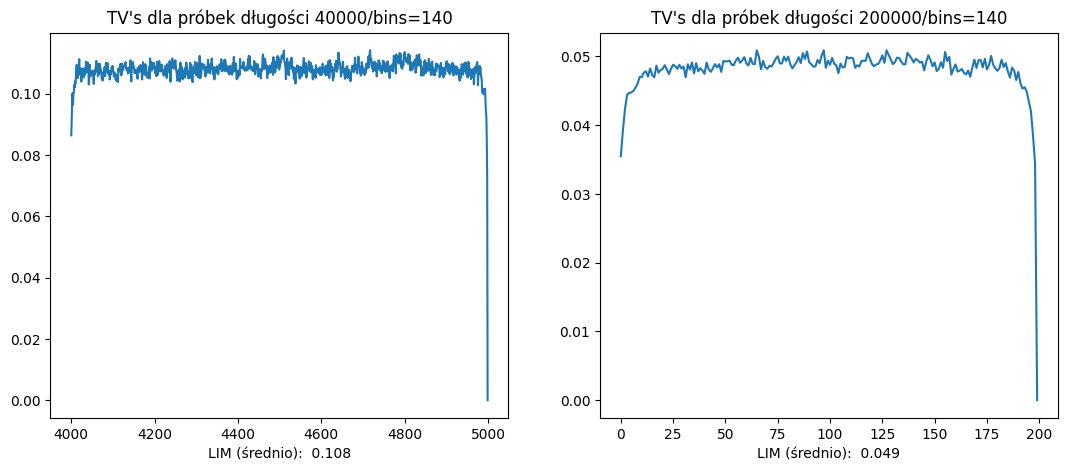

In [6]:
nburn, nsteps, dist = 4000, 8000, 1000
paths_ = paths3      # tylko próbki z grupy granicznej - ale z PRZESKOKIEM - co 1000
n_rang = np.arange(nburn,nburn+dist)
tvs = np.empty_like(n_rang, dtype=np.float32)
res =np.asarray([np.vstack([paths_[i],paths_[i+dist],paths_[i+2*dist],paths_[i+3*dist]]) for i in n_rang])    # sklejamy z przeskokiem
rozmS = res.shape[1]
Hb, xb, yb = np.histogram2d(*res[-1].T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
for i in np.arange(dist):
    path_ = res[i].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tv_ = np.abs(H_ - Hb).sum()/2
    tvs[i] = tv_
tvs *= (140/bins)**2   # podział na bins^2 zamiast 140^2
fig, (ax0, ax) = plt.subplots(1,2,figsize=(13,5))
ax0.plot(n_rang, tvs)
ax0.set_title(f"TV's dla próbek długości {rozmS}/bins={bins}");
ax0.set_xlabel(f"LIM (średnio): {tvs[100:-100].mean():6.3f}");

dist = 200
tvs2 = np.empty(dist, dtype=np.float32)
res2 =np.asarray([np.vstack([res[i],res[i+dist],res[i+2*dist],res[i+3*dist],res[i+4*dist]]) for i in range(dist)])    # sklejamy z przeskokiem
rozm2 = res2.shape[1]
Hb2, xb2, yb2 = np.histogram2d(*res2[-1].T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
for i in np.arange(dist):
    path_ = res2[i].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tv_ = np.abs(H_ - Hb2).sum()/2
    tvs2[i] = tv_
tvs2 *= (140/bins)**2   # podział na bins^2 zamiast 140^2
ax.plot(range(dist), tvs2)
ax.set_title(f"TV's dla próbek długości {rozm2}/bins={bins}");
ax.set_xlabel(f"LIM (średnio): {tvs2[50:-50].mean():6.3f}");

E = res[-1].mean(axis=0)
E2 = res2[-1].mean(axis=0)
print("Estymowana wartość oczekiwana porametrów:", E, E2)


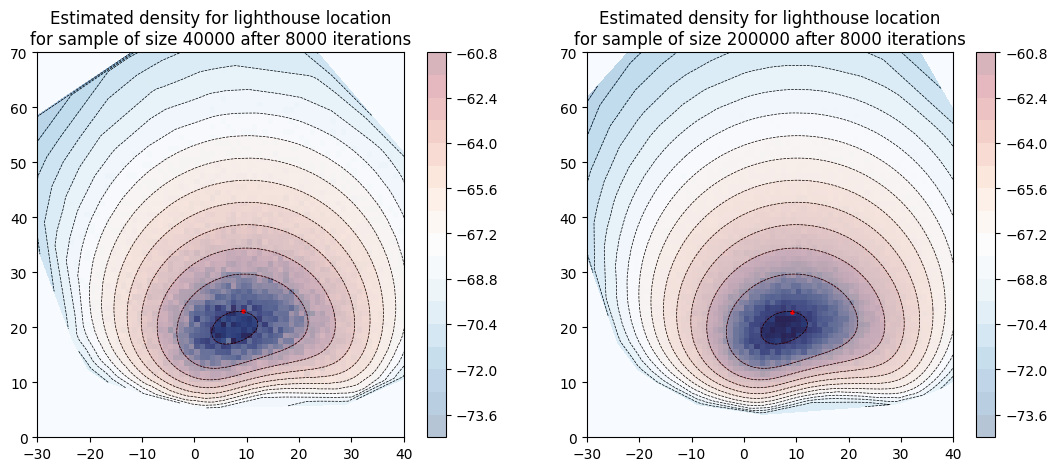

In [7]:
Xb, Yb = np.meshgrid(xb, yb)
Xb2, Yb2 = np.meshgrid(xb2, yb2)

fig, (ax0, ax) = plt.subplots(1,2,figsize=(13,5))
ax0.set_xlim(-30,40);
ax0.set_ylim(0,70);
ax0.pcolormesh(Xb, Yb, Hb.T, cmap="Blues");
ax0.set_title(f"Estimated density for lighthouse location\n"
            f"for sample of size {rozmS} after {nsteps} iterations");
logR = compute_log_prob(res[-1])
ax0.tricontour(*res[-1].T, logR, levels=15, linewidths=0.5, colors='k');
cntr0 = ax0.tricontourf(*res[-1].T, logR, levels=15, cmap="RdBu_r", alpha=.3)
fig.colorbar(cntr0, ax=ax0)

E = res[-1].mean(axis=0)
ax0.scatter(*E,s=5, color="red")

ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.pcolormesh(Xb2, Yb2, Hb2.T, cmap="Blues");
ax.set_title(f"Estimated density for lighthouse location\n"
            f"for sample of size {rozm2} after {nsteps} iterations");
logR2 = compute_log_prob(res2[-1])
ax.tricontour(*res2[-1].T, logR2, levels=15, linewidths=0.5, colors='k');
cntr2 = ax.tricontourf(*res2[-1].T, logR2, levels=15, cmap="RdBu_r", alpha=.3)
fig.colorbar(cntr2, ax=ax)

E2 = res2[-1].mean(axis=0)
ax.scatter(*E2,s=5, color="red")


A teraz **obszary ufności** w ramach zastosowań

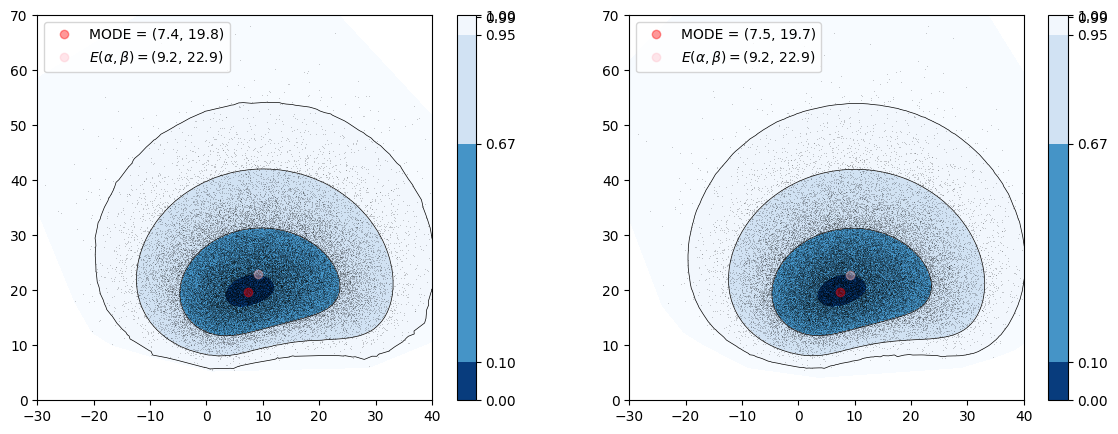

In [8]:
levels = np.argsort(logR, kind="mergesort")[::-1]
levels2 = np.argsort(logR2, kind="mergesort")[::-1]
Theta = E  # wartosci oczekiwane
Theta2 = E2
path = res[-1]
N0 = rozmS
fig, (ax,ax0) = plt.subplots(ncols=2, figsize=(14,5))
ax.plot(*path.T, ",k", alpha=.2);
ax.tricontour(*path[levels].T, np.arange(N0)/N0, levels=[0, .6667, .95, .995, 1], linewidths=0.5, colors='k')   #
ax.set_ylim(0,70); ax.set_xlim(-30,40)
cntr_ = ax.tricontourf(*path[levels].T, np.arange(N0)/N0, levels=[0, .1, .6667, .95, .995, 1], cmap="Blues_r")    #"Blues")  # "YlOrRd_r")Pastel2
mode = path[levels[0]];
ax.plot(*mode,"or", label="MODE = ({0:.1f}, {1:.1f})".format(*mode),alpha=.4);
ax.plot(*Theta,"o", color="pink", label="$E(\\alpha,\\beta)=$({0:.1f}, {1:.1f})".format(*Theta),alpha=.4);
fig.colorbar(cntr_, ax=ax, spacing='proportional', format='%.2f');
ax.legend()
path = res2[-1]
N0 = rozm2
ax0.plot(*path[::5].T, ",k", alpha=.2);
ax0.tricontour(*path[levels2].T, np.arange(N0)/N0, levels=[0, .6667, .95, .995, 1], linewidths=0.5, colors='k')   #
ax0.set_ylim(0,70); ax0.set_xlim(-30,40)
cntr0_ = ax0.tricontourf(*path[levels2].T, np.arange(N0)/N0, levels=[0, .1, .6667, .95, .995, 1], cmap="Blues_r")    #"Blues")  # "YlOrRd_r")Pastel2
mode2 = path[levels2[0]];
ax0.plot(*mode2,"or", label="MODE = ({0:.1f}, {1:.1f})".format(*mode2),alpha=.4);
ax0.plot(*Theta2,"o", color="pink", label="$E(\\alpha,\\beta)=$({0:.1f}, {1:.1f})".format(*Theta2),alpha=.4);
ax0.legend()
fig.colorbar(cntr0_, ax=ax0, spacing='proportional', format='%.2f');


### MCMC - wg emcee

#### StrechMove
... a przy okazji zmiana podejścia do parametrów (w następnym notatniku)

In [ ]:
import warnings

def log_prior(ab):
    where = ab[:, 1]<0
    ab[where, 1] = 0
    return -ab[:, 1]**(-1)

def log_likelihood(ab, Data):
    where = ab[:, 1]<0
    ab[where,1] = 0
    return -np.sum(np.log((Data - ab[:,0])**2 + ab[:,1]**2)-np.log(ab[:,1]), axis=0)

def log_posterior(ab, Data):
    warnings.simplefilter("ignore")
    return log_prior(ab) + log_likelihood(ab, Data)

def compute_log_prob(coords):
    return log_posterior(coords, D)
